# HW2
### Fatemeh Almodaresi (ID: 117000986)
### Hamidreza Kazemi (ID: ???)


-----------------------------------------

# 1 -
The degree distribution does not fit the Erdos-Reny network model because the real data does not always act like a random model. For example in many cases the degree distribution in a real network is actually following a powerlaw distribution model with a skewed tail.

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# import math
# from decimal import Decimal

In [136]:
from scipy.stats import ks_2samp

In [8]:
root='/mnt/scratch1/fatemeh/courses/hw1/'

In [39]:
adj = pd.read_csv(root+'genetic_interaction_amat.csv', sep=",")

In [40]:
len(adj)

2803

# 2 - 

# Network Evolution Model

## prerequisites

#### 1. Initialize the network

In [223]:
def initialize(m0 = 5, k = 5, m = 30, n = len(adj)):
    simAdj = [[0 for i in range(n)] for j in range(n)]
    # Target nodes for new edges 
    nodes=list(range(m0)) 

    repeated_nodes=[] 
    edgeCntr = 0
    # pure random initialization of the graph with m0 nodes and k edges
    # first guarantee that each node has at least one edge connected to it
    for i in range(m0):
        if np.sum(simAdj, axis=0)[i] == 0 and np.sum(simAdj, axis=1)[i] == 0:
            src = i
            while 1:
                dest = random.sample(range(m0), 1)[0]
                if src > dest:
                    src,dest=dest,src
                if src != dest and simAdj[src][dest] == 0:
                    break
            simAdj[src][dest] = 1
            edgeCntr+=1
            repeated_nodes += [src]
            repeated_nodes += [dest]

    print('At this point we guarantee that each node has at least one edge connected to it')
    # then create the rest of the random edges for the inital graph    
    while edgeCntr < k:
        randEdge = random.sample(range(m0*m0), k-edgeCntr)
        for e in randEdge:
            i = int(e/m0)
            j = int(e%m0)
            if i > j:
                i,j=j,i
            if i != j and simAdj[i][j] == 0:
                simAdj[i][j] = 1
                repeated_nodes += [i]
                repeated_nodes += [j]
                edgeCntr += 1
    print('Random graph initialization done')
    return simAdj, repeated_nodes

#### 2. make the adjacency matrix symetric and convert it to a dataframe

In [108]:
def convert2AdjDF(halfAdj):
    for i in range(len(halfAdj)):
        for j in range(i+1, len(halfAdj)):
            halfAdj[j][i] = halfAdj[i][j]
    return pd.DataFrame.from_records(halfAdj)

#### 3. get Degree Distribution

In [130]:
def getDegDist(adjMat):
    degrees = adjMat.sum(1)
    degreeDist = degrees.value_counts()
    degreeDist = degreeDist.sort_index()
    return degreeDist/len(degrees)

## Barabasi-Albert Model

To find the best fit for BA model to the observed data, first calculate the average degree of the observed data and later set parameters m and k and m0 accordingly

In [256]:
degrees = adj.sum(1)
degrees.mean()

23.998572957545488

Choose m to be *24* and start with m0 = 24 at least and set k = 2 * 24

In [264]:
# List of existing nodes, with nodes repeated once for each adjacent edge 
# Start adding the other n-m nodes. The first node is m. 
n = len(adj)
m0 = 24
k = 48
m = 24
ba_adj, repeated_nodes = initialize(m0, k, m)
newNode=m0
while newNode<n: 
    cntr = 0
    while cntr < m:
        dests = random.sample(repeated_nodes, m)
#         print(dests)
        for d in dests:
            src = newNode
            dest = d
            if src > dest:
                src,dest=dest,src
            if src != dest and ba_adj[src][dest] != 1:
                ba_adj[src][dest] = 1
                repeated_nodes += [src]
                repeated_nodes += [dest]
                cntr+=1
    newNode+=1
    print(newNode, end="\r")
ba_adj_df = convert2AdjDF(ba_adj)

At this point we guarantee that each node has at least one edge connected to it
Random graph initialization done


## duplication model

In [250]:
p = 0.44
r = 0.10
n = len(adj)
m0 = 2
k = 1
genDup, repeated_nodes = initialize(m0, k)
newNode=m0
while newNode<n: 
    cntr = 0
    node = random.sample(range(newNode-1), 1)[0]

#         print(dests)
    for i in range(n):
        if genDup[node][i] == 1 and np.random.rand() > p: # with probability p remove the edge (or don't add it!)
            genDup[newNode][i] = 1
        if genDup[i][node] == 1 and np.random.rand() > p:
            genDup[i][newNode] = 1
    for i in range(node+1, n):
        if genDup[node][i] == 0:
            if np.random.rand() < r/newNode:
                genDup[node][i] = 1
    for i in range(node-1):
        if genDup[i][node] == 0:
            if np.random.rand() < r/newNode:
                genDup[i][node] = 1
    newNode+=1
    print(newNode, end="\r")
genDup_adj_df = convert2AdjDF(genDup)

At this point we guarantee that each node has at least one edge connected to it
Random graph initialization done


## Degree Distribution Comparison

##### Qualitatively

Text(0.5, 1.0, 'degree distribution (log-log)')

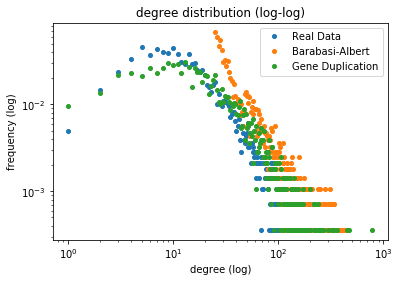

In [265]:
ax = plt.gca()

expDegreeDist = getDegDist(adj)
ax.loglog(expDegreeDist.index+1, expDegreeDist.values,marker = 'o', linewidth = 0, markersize = 4, label="Real Data")

baDegreeDist = getDegDist(ba_adj_df)
ax.loglog(baDegreeDist.index+1, baDegreeDist.values,marker = 'o', linewidth = 0, markersize = 4, label="Barabasi-Albert")

gdDegreeDist = getDegDist(genDup_adj_df)
ax.loglog(gdDegreeDist.index+1, gdDegreeDist.values,marker = 'o', linewidth = 0, markersize = 4, label="Gene Duplication")

ax.legend()
plt.xlabel("degree (log)")
plt.ylabel("frequency (log)")
plt.title("degree distribution (log-log)")

#### Quantitatively
##### Using Kolmogorov-Smirnov test

If we see enough evidence we reject the hypothesis that the two distributions are the same (null hypothesis),
Otherwise, we just can say that we didn't find enough evidence to reject the fact that the data on both model and real samples came from the same distribution

1. If ks stat value is small that means that the peak difference between the CDF of the two distributions is small
2. If the p-value is high, that means that we cannot rely on the ks stat val.

Combining these two points, we cannot reject the null hypothesis of the two distributions being the same if the ks stat value is too small or the p-value is too large.

To be more concrete:
    
    
    If the two samples were randomly sampled from identical populations, what is the probability that the two cumulative frequency distributions would be as far apart as observed?
    
    More precisely, what is the chance that the value of the Komogorov-Smirnov D statistic would be as large or larger than observed?
    
    If the P value is small, conclude that the two groups were sampled from populations with different distributions. The populations may differ in median, variability or the shape of the distribution.

In [266]:
ba_d, ba_pval = ks_2samp(expDegreeDist, baDegreeDist)
gd_d, gd_pval = ks_2samp(expDegreeDist, gdDegreeDist)
print('The ks stat and p-value for each model for the degree distribution compared to the real data')
print('1. Barabasi-Albert model: {0:1.3g}, {1:1.2e}'.
     format(round(ba_d, 3), ba_pval))
print('2. Gene Duplication model: {0:1.3g}, {1:1.2e}'.
     format(round(gd_d, 3) , gd_pval))

The ks stat and p-value for each model for the degree distribution compared to the real data
1. Barabasi-Albert model: 0.157, 1.59e-02
2. Gene Duplication model: 0.07, 7.73e-01


Considering those, using a trial and error process, we can find r and p values that make the model's degree distribution both visually and statistically close to the real data degree distribution.

For Barabasi-Albert model how ever, although there is a solution to best fit the model to the experimental data (choose k = 2m and m being the average degree of the observed network), yet, the KS test is rejected both by D and p-value and the plot also shows the difference of the distributions in "smaller degree" frequencies.


Both of the quantitative and qualitative trials show that the gene duplication model is a better fit to the real data

# Which one from image 6.15 may fit the best?

The options are divided between basic BA model, and its extensions, node deletion, initial attractiveness, n internal links, accelerated growth, and aging.

The main issue with basic BA model is that the model is not a good fit for low degree node distribution. Hence node deletion and accelerated growth models are definitely not gonna help this situation. They will only make the network grow faster with larger jumps or will just make the gamma larger which is again (if not diminishing the whole network) making the growth rate of degrees faster.

Internal links is gonna make the BA network more homogenous and closer to the random networks as n increases and does not target the low degree edges specifically so this one is not a good option too.

Initial attractiveness, as you can see in the last cell in our quick test, is gonna add a curve at the low degree section, but that ends in changing the frequency of all the degrees and not just for the lower degrees although this seems to be the closest shape we want.

For the last extension, Aging, in the following lines we implemented the aging version of Barabasi-Albert with a small positive v which could improve the KS test results and also made the model visually a little bit closer to the real data degree distribution. We think it is not the model that can define this data, but among the options we have from different extensions of BA model (including no extensions) we think this model is the best choice.

#### Aging test

In [277]:
# List of existing nodes, with nodes repeated once for each adjacent edge 
# Start adding the other n-m nodes. The first node is m. 
n = len(adj)
m0 = 24
k = 48
m = 24
v = 0.2
ba_adj, repeated_nodes = initialize(m0, k, m)
newNode=m0
for i in range(m, n):
    degs=np.sum(ba_adj, axis=0)
    for j in range(i):
        degs[j] = degs[j]*((i - j)**(-v))
    p_attach=degs/np.sum(degs)
    ixs=np.random.choice(np.arange(i), p=p_attach[:i], size=m)
    for j in ixs:
        ba_adj[i][j] =1
        ba_adj[j][i] =1
    print(i, end="\r")

ba_adj_df = convert2AdjDF(ba_adj)

At this point we guarantee that each node has at least one edge connected to it
Random graph initialization done


The ks stat and p-value for each model for the degree distribution compared to the real data
1. Barabasi-Albert model: 0.114, 2.28e-01


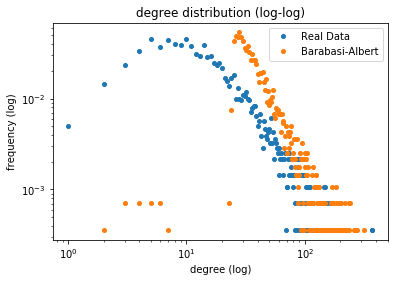

In [279]:
ax = plt.gca()

expDegreeDist = getDegDist(adj)
ax.loglog(expDegreeDist.index+1, expDegreeDist.values,marker = 'o', linewidth = 0, markersize = 4, label="Real Data")

baDegreeDist = getDegDist(ba_adj_df)
ax.loglog(baDegreeDist.index+1, baDegreeDist.values,marker = 'o', linewidth = 0, markersize = 4, label="Barabasi-Albert")

ax.legend()
plt.xlabel("degree (log)")
plt.ylabel("frequency (log)")
plt.title("degree distribution (log-log)")
ba_d, ba_pval = ks_2samp(expDegreeDist, baDegreeDist)
print('The ks stat and p-value for each model for the degree distribution compared to the real data')
print('1. Barabasi-Albert model: {0:1.3g}, {1:1.2e}'.
     format(round(ba_d, 3), ba_pval))

#### Initial Attractiveness quick test

Text(0, 0.5, 'frequency (log)')

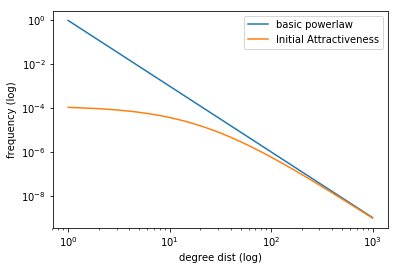

In [288]:
x = []
y = []
z = []
for i in range(1, 1000):
    x += [i]
    y += [(i)**-3]
    z += [(20+i)**-3]
ax = plt.gca()
ax.loglog(x, y, label="basic powerlaw")
ax.loglog(x, z, label="Initial Attractiveness")
ax.legend()
plt.xlabel("degree dist (log)")
plt.ylabel("frequency (log)")